<a href="https://colab.research.google.com/github/sametakar/Derin-Evrisim-Sinir-Agi-ile-Duygu-Tanima/blob/main/Duygu_Tanima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DERİN EVRİŞİM SİNİR AĞI (CNN) İLE DUYGU TANIMA UYGULAMASI

---


* **Programlama dili:** Python 

* **Kütüphane:** Keras/TensorFlow

* **Donanım/Bulut:** Google Cloud, ücretsiz Colab servisi (Tesla K80 GPU)

* **Veri Seti:** [KAGGLE- Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)

* **Yöntem:** Derin Öğrenme

* **Model:** 5 Evrişim Katmanlı Sinir Ağları Modeli




### Google Colab Kimlik Doğrulama İşlemi

Klasik Colab kimlik doğrulama işlemi ile başlayalım!

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
import os

os.chdir('/gdrive/My Drive/Derin Öğrenme ve Yapay Sinir Ağları - Final Projesi')

In [ ]:
!ls 

data  Duygu_Tanima.ipynb  images


### **UYGULAMA BAŞLANGICI**
Gerekli paketlerin yüklenmesi...

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

**Veri setinin okunması...**

Bize verilen veriseti **35887 ** satır ve **3** sütundan oluşuyor.

In [ ]:
root = '/gdrive/My Drive/Derin Öğrenme ve Yapay Sinir Ağları - Final Projesi/'

data = pd.read_csv(root + 'data/fer2013.csv')
data.shape

(35887, 3)

**Veriden bir kısım görelim!**

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


**Eğitim ve test performansının ölçüldüğü veri sayılarını inceleyelim.**

In [ ]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

**Usage** kolonunda verisetindeki örnekler kaç gruba ayrıldığını görebiliriz. 
[Kaggle](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)da genelde bu şekilde submit sonrası asıl test edilmesi için verisetinden bir kısmını **"PrivateTest"** olarak ayırırlar.

### **EĞİTİM VERİSİ İÇİN ÖN İŞLEME ADIMLARI**

In [ ]:
np.unique(data["Usage"].values.ravel())

print('Eğitim setindeki örnek sayısı: %d'%(len(data[data.Usage == "Training"])))

Eğitim setindeki örnek sayısı: 28709


Eğitim işlemi için veri kümesinde ayrılmış olan **Training** kısmını alıyoruz.

In [ ]:
train_data = data [data.Usage == "Training"] #sadece eğitim örneklerini train_data değişkenine aldık

In [ ]:
#eğitim örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
train_pixels = train_data.pixels.str.split(" ").tolist() 

train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)

print(train_images)

print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [ ]:
#Görüntüyü 48x48 piksel şeklinde göstermek için bir fonksiyon tanımlayalım
def show(img):
    show_image = img.reshape(48,48)
    
    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

**Eğitim kümesinden bir örnek görsel**

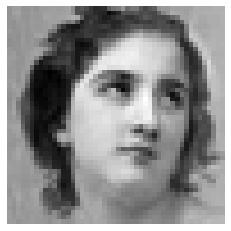

In [ ]:
#Veri kümesinden 
show(train_images[970])

**Eğitim kümesinde kaç sınıf bulunuyor bunu görelim.**

In [ ]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Farklı yüz ifadelerinin sayısı: %d'%train_labels_count)

Farklı yüz ifadelerinin sayısı: 7


**One Hot ile eğitim kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim.**

In [ ]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [ ]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)

y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


### TEST VERİSİ ÖN İŞLEME ADIMLARI


In [ ]:
np.unique(data["Usage"].values.ravel()) 

print('Test verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "PublicTest"])))

Test verisetindeki örnek sayısı: 3589


Eğitim işlemi için veri kümesinde ayrılmış olan **PublicTest** kısmını alıyoruz.

In [ ]:
test_data = data[data.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)

#test örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık

(3589, 2304)


**Test kümesinden bir örnek görsel**

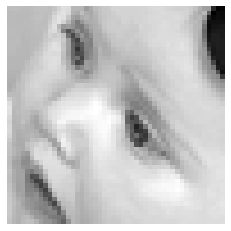

In [ ]:
#bir test örneği gösterelim
show(test_images[300])

**One Hot ile test kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim.**

In [ ]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


### TEST KÜMESİNDEN ÖRNEK GÖRÜNTÜLER

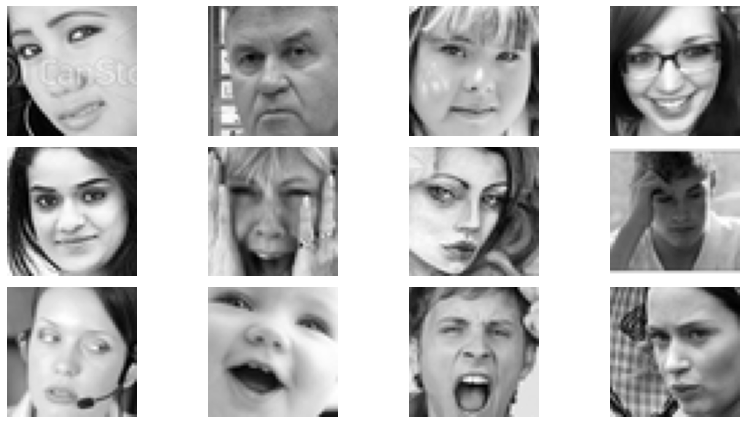

In [ ]:
#test verisetinden örneklerden bir kaçını toplu halde görelim
plt.figure(0, figsize=(12,6))
for i in range(1,13):
  plt.subplot(3, 4, i)
  plt.axis('off')

  image = test_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

## DERİN EVRİŞİMLİ SİNİR AĞI MODELİ TANIMLANMASI

Kullandığımız modeli görselleştirirsek: 


---


![CNNMODEL](https://drive.google.com/uc?export=view&id=1npoZADIuPfMlEkRTKW4CCcnNKVlLE3OK)

## Görseldeki modeli yazalım:



In [ ]:
model = Sequential()

#1. KATMAN
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#2. KATMAN

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### 3. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))


### 4. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 5. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))#%60 unutma işlemi(nöron silme-dropout)

### Çıkış katmanı

model.add(Dense(7))
model.add(Activation('softmax')) #Sınıflama işlemi (7 duygu sınıfı var)

#opmizasyon ve başarım hesaplama metriklerinin belirlenmesi
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

#model özetini görselleştirelim
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0

**Eğtim ve Test kümelerinin eleman sayısı, yükseklik ve genişlik, kanalsayısı bilgilerini ekrana yazdıralım.**

In [ ]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print('Train:', x_train.shape)
print('Test:', x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


**Eğitim ve Test kümelerinin eleman ve duygu sınıf sayısı.**

In [ ]:
print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


**Eğitim işleminin gerçekleşmesini istediğimiz epoch, batchsize gibi değerlerin belirlenmesi ve eğitim sonucunda ağırlıkların .h5 dosyası olarak kaydedilmesi işlemleri**

In [ ]:
# en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath=root + 'data/face_model.h5', verbose=1, save_best_only=True)

epochs = 20
batchSize = 100

# modeli çalıştır

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

Epoch 1/20
288/288 - 16s - loss: 1.9938 - accuracy: 0.2555 - val_loss: 1.6025 - val_accuracy: 0.3711

Epoch 00001: val_loss improved from inf to 1.60254, saving model to /gdrive/My Drive/Derin Öğrenme ve Yapay Sinir Ağları - Final Projesi/data/face_model.h5
Epoch 2/20
288/288 - 8s - loss: 1.6534 - accuracy: 0.3514 - val_loss: 1.4696 - val_accuracy: 0.4347

Epoch 00002: val_loss improved from 1.60254 to 1.46958, saving model to /gdrive/My Drive/Derin Öğrenme ve Yapay Sinir Ağları - Final Projesi/data/face_model.h5
Epoch 3/20
288/288 - 8s - loss: 1.5360 - accuracy: 0.3995 - val_loss: 1.4151 - val_accuracy: 0.4544

Epoch 00003: val_loss improved from 1.46958 to 1.41511, saving model to /gdrive/My Drive/Derin Öğrenme ve Yapay Sinir Ağları - Final Projesi/data/face_model.h5
Epoch 4/20
288/288 - 8s - loss: 1.4599 - accuracy: 0.4350 - val_loss: 1.3518 - val_accuracy: 0.4770

Epoch 00004: val_loss improved from 1.41511 to 1.35179, saving model to /gdrive/My Drive/Derin Öğrenme ve Yapay Sinir A

### **Eğitim sonucu elde edilen Eğitim ve Geçerleme (Validation) sonuçlarının grafiksel olarak ifade edilip ekrarna yazdırılması işlemleri.**

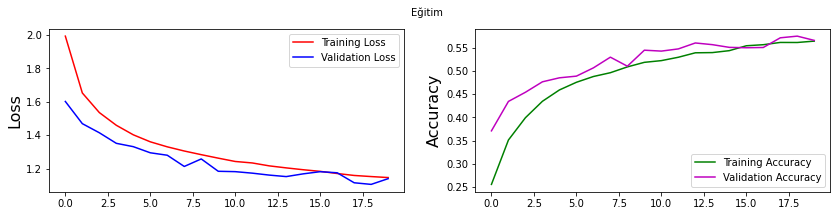

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()


Kaggle submit edecek gibi **PrivateTest** örnekleri ile test edelim.

In [ ]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))

test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [ ]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [ ]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [ ]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu:", score)

PrivateTest üzerindeki doğruluk durumu: [1.1234499216079712, 0.5639454126358032]


 **Veri kümseindeki eğitim kısmı ile modeli eğitip test için ayırılan veri ile test işlemlerini yaptık. **

---

## Farklı görüntülerle test işlemlerini yapıp sonuçları görselleştirelim.

In [ ]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

**Daha önceki eğitimde kaydettiğimiz modelin hesapladığını öğrenilmiş ağırlık dosyasını kullanıyoruz.**

In [ ]:
# en iyi ağırlıkları yükle
model_best = load_model(root + 'data/face_model.h5')


In [ ]:
os.chdir(root + 'images')

In [ ]:
!ls

brando.png	   javierbardem.jpg  lotr1.jpg	       test2.jpg  test.jpg
emojis		   kemal_sunal2.jpg  lotr2.jpg	       test3.jpg
javierbardem2.jpg  kemal_sunal.jpg   robertdeniro.jpg  test4.jpg


In [ ]:
#test_image=x_test_private[60] # eğer veri kümesinden bir görsel denemek isterseniz  
                               # burada [] içine rastgele bir görsel numarası atayarak test edebilirsiniz!

image_path = root + "images/robertdeniro.jpg"

test_image_original = image.load_img(image_path) # orjinal renkli görüntü

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


array([[0.2878128 , 0.0156848 , 0.29374653, 0.08346332, 0.19182329,
        0.05729204, 0.07017724]], dtype=float32)

### SONUÇLARIN GÖRSELLEŞTİRİLMESİ ADIMLARI

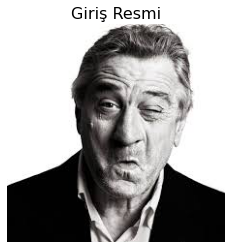

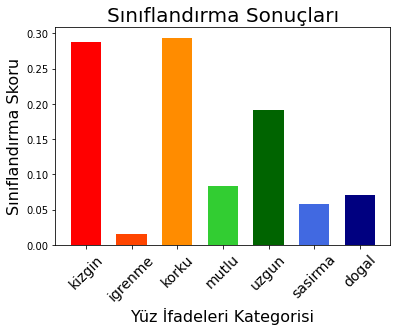

Sınıflandırma sonucu en yüksek oranla: korku


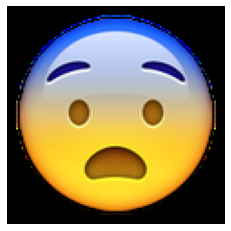

In [ ]:
#sınıflarımız 7 adet duygu durumumuz
class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'sasirma', 'dogal']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4  #bar genişliği

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

# test resmimizi çizdirelim

plt.imshow(test_image_original)
plt.title('Giriş Resmi', fontsize=16)
plt.axis('off')
plt.show()

#sonuçlarımızı renklendirelim

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Sınıflandırma Sonuçları", fontsize=20)
plt.xlabel("Yüz İfadeleri Kategorisi",fontsize=16)
plt.ylabel("Sınıflandırma Skoru",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])

# en yüksek skorlu duyguya karşılık emoji çizdirelim

emojis_img = image.load_img(root + 'images/emojis/%s.png'% str(class_names[np.argmax(results)]))

plt.imshow(emojis_img)
plt.axis('off')
plt.show()
